In [1]:
import pandas as pd

train = pd.read_csv('dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv('dm2_dataset_2425_imdb/test30_clf.csv')

In [2]:
# Drop observations where titleType is 'videoGame'
train = train[train['titleType'] != 'videoGame']
test = test[test['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
train['titleType'] = train['titleType'].map(titletype_mapping)
test['titleType'] = test['titleType'].map(titletype_mapping)

# Check the new unique values
print("New unique values in titleType:", train['titleType'].unique())

New unique values in titleType: ['movie' 'short' 'tvEpisode' 'tvSeries' 'video' 'tvSpecial']


In [3]:
X_train = train.drop(columns=['titleType', 'canHaveEpisodes'])
y_train = train['titleType']

X_test = test.drop(columns=['titleType', 'canHaveEpisodes'])
y_test = test['titleType']

In [4]:
from sklearn.preprocessing import LabelEncoder

# One-hot encode y_train for categorical_crossentropy
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Bagging

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the search space for hyperparameters
search_map = {
    'n_estimators': randint(10, 100),
    'max_features': uniform(0.1, 0.9),
    'max_samples': uniform(0.1, 0.9),
    'estimator__max_depth': randint(1, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
}

# Set up cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Create BaggingClassifier for search
search_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42, n_jobs=-1)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=search_map,
    n_iter=5,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters found: {'estimator__max_depth': 16, 'estimator__min_samples_leaf': 15, 'estimator__min_samples_split': 16, 'max_features': 0.6565474083997785, 'max_samples': 0.4442157921404465, 'n_estimators': 73}


In [18]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       movie       0.88      0.96      0.92     12947
       short       0.91      0.97      0.94      4994
   tvEpisode       0.95      0.98      0.97     21249
    tvSeries       0.82      0.58      0.68      3247
   tvSpecial       0.75      0.09      0.16       345
       video       0.85      0.29      0.43      1545

    accuracy                           0.91     44327
   macro avg       0.86      0.65      0.68     44327
weighted avg       0.91      0.91      0.90     44327



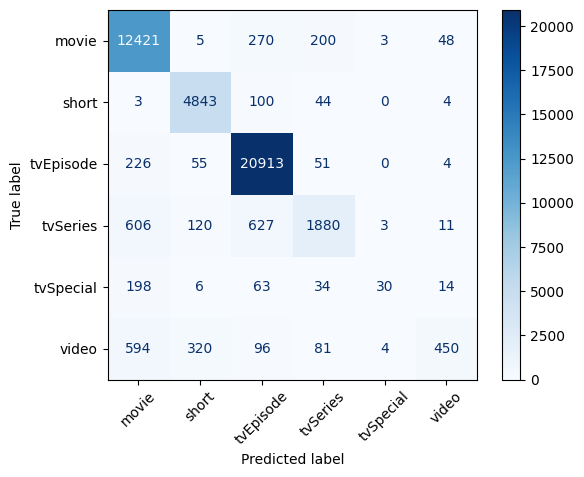

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', xticks_rotation=45)

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Define search space for hyperparameters
search_map_rf = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': uniform(0.1, 0.9),
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Set up cross-validation strategy
cv_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Create RandomForestClassifier for search
search_model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=search_model_rf,
    param_distributions=search_map_rf,
    n_iter=50,
    scoring='accuracy',
    cv=cv_rf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)
best_model_rf = random_search_rf.best_estimator_
print("Best parameters found for Random Forest:", random_search_rf.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found for Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7361716094628554, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 42}


              precision    recall  f1-score   support

       movie       0.91      0.95      0.93     12947
       short       0.93      0.96      0.95      4994
   tvEpisode       0.96      0.98      0.97     21249
    tvSeries       0.77      0.70      0.73      3247
   tvSpecial       0.70      0.27      0.39       345
       video       0.77      0.42      0.55      1545

    accuracy                           0.92     44327
   macro avg       0.84      0.71      0.75     44327
weighted avg       0.92      0.92      0.92     44327



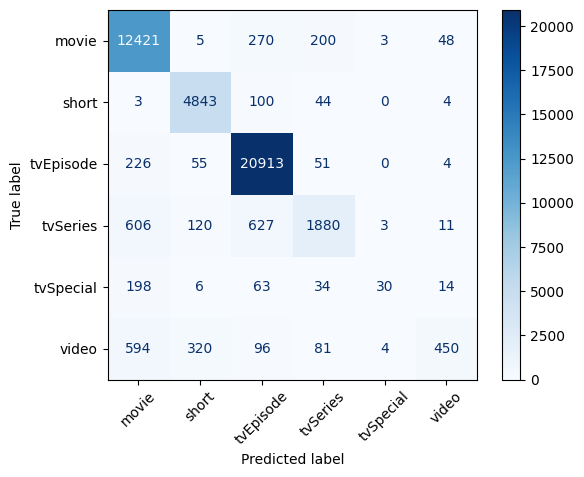

In [29]:
# Predict on the test set
y_pred = best_model_rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', xticks_rotation=45)

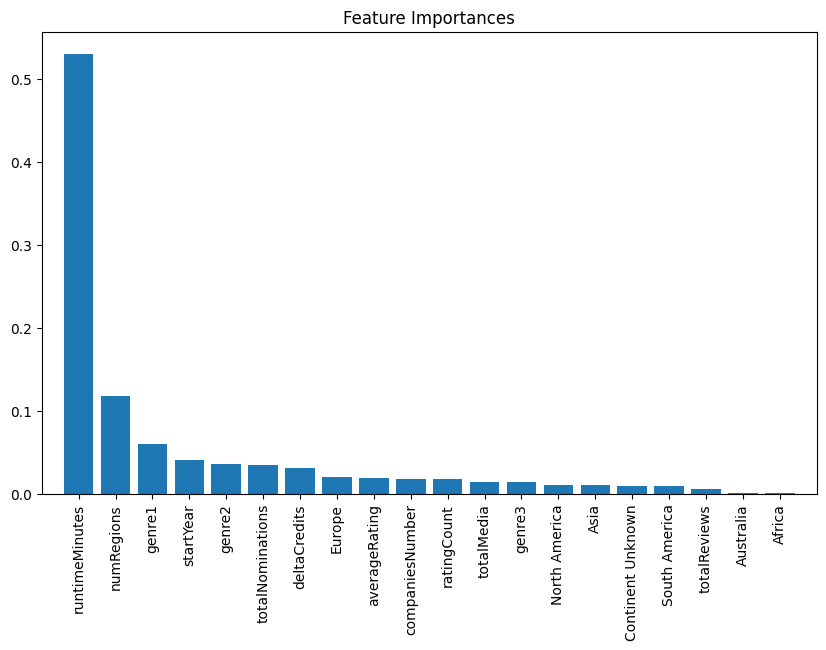

In [30]:
# Feature importance
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = best_model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Boosting

In [26]:
from sklearn.ensemble import AdaBoostClassifier

# Define search space for hyperparameters
search_map_ab = {
    'n_estimators': randint(10, 100),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
}

# Set up cross-validation strategy
cv_ab = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Create AdaBoostClassifier for search
search_model_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(), random_state=42
)

# Randomized search
random_search_ab = RandomizedSearchCV(
    estimator=search_model_ab,
    param_distributions=search_map_ab,
    n_iter=5,
    scoring='accuracy',
    cv=cv_ab,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_ab.fit(X_train, y_train)
best_model_ab = random_search_ab.best_estimator_
print("Best parameters found for AdaBoost:", random_search_ab.best_params_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Best parameters found for AdaBoost: {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 16, 'estimator__min_samples_split': 16, 'learning_rate': 0.46606998421703594, 'n_estimators': 56}


              precision    recall  f1-score   support

       movie       0.87      0.95      0.91     12947
       short       0.92      0.95      0.94      4994
   tvEpisode       0.96      0.97      0.96     21249
    tvSeries       0.76      0.60      0.67      3247
   tvSpecial       0.76      0.11      0.19       345
       video       0.69      0.34      0.46      1545

    accuracy                           0.91     44327
   macro avg       0.83      0.65      0.69     44327
weighted avg       0.90      0.91      0.90     44327



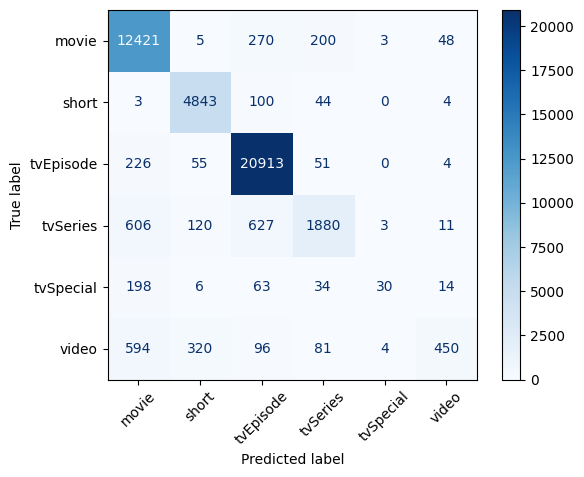

In [27]:
# Predict on the test set
y_pred = best_model_ab.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=le.classes_, cmap='Blues', xticks_rotation=45)